In [1]:
from data_processing import *

train_data, OUT_DIM = load_create_ellipticpp(timestep=(1,32))
test_data, OUT_DIM = load_create_ellipticpp(timestep=(33,42))

# loader = split_into_batches(data, num_batches=batch_size, num_hops=2, num_neighbours=100)
# num_features = next(iter(loader)).x.shape[-1]
# data


In [2]:
# maybe remvoe mask and cosnider temporal split for elliptic++
# dataloader (from pt) - implement sampler here -> neighourloader
# summary stats on avg degree of a node when considering ([-1,-1] neighbourhoods)
# graphsage/gat with full neighbourhood, 75%/50%/25% reduction in neighbourhood

In [3]:
# from torch.utils.data import Sampler
# from torch_geometric.loader import DataLoader
# from typing import Iterator, Iterable, List

# class customGraphSampler(Sampler[List[int]]):
#     def __init__(self, data: Iterable, batch_size: int=32, positive_label: int=1, negative_label: int=0) -> None:
#         self.data = data
#         self.batch_size = batch_size
#         self.positive_label = positive_label
#         self.negative_label = negative_label

#     # number of batches
#     # @TODO: recompute based on labels
#     def __len__(self) -> int:
#         return (len(self.data.x) + self.batch_size - 1) // self.batch_size

#     def _is_half_batch_size(self, counter_sample) -> int:
#         return counter_sample >= self.batch_size // 2

#     def __iter__(self) -> Iterator[int]:
#         batch = []
#         # torch where y == 0, y == 1 -> select first batch_size idx `y == 0` and batch_size - selection_size `y == 1`
        
#         # ****@TODO: iterate over the entire dataset and add to single list? -- and discard non relevant batches
#         ### get all neighbours
#         # @TODO: iterate over the entire dataset but keep some other batches as well
#         # @TODO: accumulate positive and negative in separate lists and then combine?
#         # @TODO: sample from two lists and add indices

#         # @TODO: shuffle indices?
#         self.sizes = 2

#         # [1,0,1,0,2_]
#         # pos = 2
#         # neg = 2
#         # idx = 4 -> idx+1 = 5
#         # len = 5

#         counter_positive_label = 0
#         counter_negative_label = 0
#         for idx, label in enumerate(self.data.y):
#             if label == self.positive_label and not self._is_half_batch_size(counter_positive_label) and idx in self.data.edge_index[0]:
#                 batch += [idx]
#                 counter_positive_label += 1
#             elif label == self.negative_label and not self._is_half_batch_size(counter_negative_label) and idx in self.data.edge_index[0]:
#                 batch += [idx]
#                 counter_negative_label += 1

#             if (len(batch) == self.batch_size):
#                 # print(batch)
#                 # yield self.data.subgraph(torch.as_tensor(batch))
#                 yield batch
#                 batch = []
#                 counter_positive_label = 0
#                 counter_negative_label = 0

# # get node idx (Y) -> make batch (Y) -> get ALL neibghours of idx (in n hops)
# # separate graph into subgraphs (where each subgraph = 64 nodes + neighbours) -> make batches ...

# # s = customGraphSampler(d, batch_size=6, positive_label=0, negative_label=1) # generate indices to form a batch
# # da = DataLoader(dataset=d.x, sampler=s, batch_size=5) # go over the entire dataset (here, list of node values) and create a batch from the sampled indices

In [80]:
from torch.utils.data import Sampler
from torch_geometric.loader import DataLoader
from typing import Iterator, Iterable, List

class customGraphSampler(Sampler[List[int]]):
    def __init__(self, data: Iterable, batch_size: int=32, positive_label: int=1, negative_label: int=0) -> None:
        torch.manual_seed(42)

        self.data = data
        self.batch_size = batch_size
        self.positive_label = positive_label
        self.negative_label = negative_label

        self.y_positive_idx = torch.where(self.data.y == positive_label, 1, 0).nonzero().squeeze()
        self.y_positive_idx = self.y_positive_idx[torch.randperm(self.y_positive_idx.size()[0])]

        self.y_negative_idx = torch.where(self.data.y == negative_label, 1, 0).nonzero().squeeze()
        self.y_negative_idx = self.y_negative_idx[torch.randperm(self.y_negative_idx.size()[0])]

    # number of batches
    # @TODO: recompute based on labels
    def __len__(self) -> int:
        return (len(self.data.x) + self.batch_size - 1) // self.batch_size

    def _is_half_batch_size(self, counter_sample) -> int:
        return counter_sample >= self.batch_size // 2

    def __iter__(self) -> Iterator[int]:
        batch = []
        # torch where y == 0, y == 1 -> select first batch_size idx `y == 0` and batch_size - selection_size `y == 1`
        
        # ****@TODO: iterate over the entire dataset and add to single list? -- and discard non relevant batches
        ### get all neighbours
        # @TODO: iterate over the entire dataset but keep some other batches as well
        # @TODO: accumulate positive and negative in separate lists and then combine?
        # @TODO: sample from two lists and add indices

        # @TODO: shuffle indices?

        print(self.y_positive_idx.shape)
        print(self.y_negative_idx.shape)

        aux_y_positive_idx = self.y_positive_idx
        aux_y_negative_idx = self.y_negative_idx

        half_batch_size = self.batch_size // 2

        while aux_y_positive_idx.shape[0] >= half_batch_size and aux_y_negative_idx.shape[0] >= half_batch_size:
            positive_labels = aux_y_positive_idx[:half_batch_size]
            aux_y_positive_idx = aux_y_positive_idx[half_batch_size:]

            negative_labels = aux_y_negative_idx[:half_batch_size]
            aux_y_negative_idx = aux_y_negative_idx[half_batch_size:]

            batch = torch.concat([positive_labels, negative_labels], dim=-1)

            yield batch

# add hops to get neighbours of neighbours
# also include all selected nodes
def select_nodes_from_central(data: Data, nodes: torch.Tensor):
    edge_mask = [data.edge_index[:,torch.where(data.edge_index == node, 1, 0)[0].nonzero().squeeze(-1)] for node in nodes]
    edge_index = torch.concat(edge_mask, dim=1)

    print(edge_index)

    node_new_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(edge_index.unique().tolist())}
    for old_idx, new_idx in node_new_idx_map.items():
        edge_index[edge_index == old_idx] = new_idx

    all_old_nodes_idx = list(node_new_idx_map.keys())
    return edge_index, all_old_nodes_idx

def split(data: Data, sampler):
    batch_graph = []
    for sample in sampler:
        edge_index, old_idx = select_nodes_from_central(data, sample)
        batch_graph += [
            Data(x=data.x[old_idx,:],
                 y=data.y[old_idx],
                 edge_index=edge_index,
                 train_mask = data.y[sample])
        ]
        print(sample.shape[0])
        print(sum([s.item() in old_idx for s in sample])/sample.shape[0])
        print(sample)
        print(old_idx)
        break

    return batch_graph

# get node idx (Y) -> make batch (Y) -> get ALL neibghours of idx (in n hops)
# separate graph into subgraphs (where each subgraph = 64 nodes + neighbours) -> make batches ...

# s = customGraphSampler(d, batch_size=6, positive_label=0, negative_label=1) # generate indices to form a batch
# da = DataLoader(dataset=d.x, sampler=s, batch_size=5) # go over the entire dataset (here, list of node values) and create a batch from the sampled indices

In [81]:
batch_sampler = customGraphSampler(train_data, batch_size=5, positive_label=0, negative_label=1) # generate indices to form a batch
subgraphs = split(train_data, batch_sampler)
train_data_batches = DataLoader(subgraphs)

torch.Size([18456])
torch.Size([212521])
tensor([[483418, 483418, 398215, 398215],
        [492824, 509093, 191336,   6430]], device='cuda:0')
4
0.5
tensor([483418, 459271, 258212, 398215], device='cuda:0')
[6430, 191336, 398215, 483418, 492824, 509093]


In [43]:
batch_sampler = customGraphSampler(test_data, batch_size=64, positive_label=0, negative_label=1) # generate indices to form a batch
subgraphs = split(test_data, batch_sampler)
test_data_batches = DataLoader(subgraphs)

torch.Size([7346])
torch.Size([71363])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor(43, device='cuda:0')


In [44]:
s = next(iter(train_data_batches))
s.y[s.train_mask]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

# remove timestep attribute !!!!

In [8]:
# from collections import Counter

# sample = next(iter(loader))
# (sample.y.tolist())

# Counter(sample.y.tolist())

In [9]:
# from torch_geometric.datasets import elliptic

# da = elliptic.EllipticBitcoinDataset("./").data.to("cuda")

In [10]:
# loader = split_into_batches(da, num_batches=100000, num_neighbours=100, num_hops=2)

In [11]:
# imbalanced dataset -> try to sample in a batch 64 central nodes - 32 class 0, 32 class 1
# use 2 neighbourloaders -> one for central node with custom sampling, one with random for neighbours (using node idxs)

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class SAGE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, **layer_paras):
        super().__init__()

        self.num_layers = layer_paras.pop("num_layers",1)
        self.hidden_dim = layer_paras.pop("hidden_channels")
        self.cached = layer_paras.pop("cached", True)

        self.dropout = layer_paras.pop("dropout", 0.0)

        self.conv_layers = []

        self.conv_layers += [
            SAGEConv(in_dim, self.hidden_dim) # input layer; cached=True => for transductive learning
        ]
        for _ in range(self.num_layers-2):
            self.conv_layers += [
                SAGEConv(self.hidden_dim, self.hidden_dim)
            ]
        self.conv_layers += [
            SAGEConv(self.hidden_dim, out_dim) # output layer; cached=True => for transductive learning
        ]

        self.conv_layers = torch.nn.ParameterList(self.conv_layers)

    def forward(self, x, edge_index):
        for conv in self.conv_layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.conv_layers[-1](x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
paras = {
    'lr':0.01,
    'num_layers':3,
    'hidden_channels':55,
    'dropout':0.4,
    'batchnorm': False,
    'l2':5e-7,
    'cached': True,
}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SAGE(in_dim=55, out_dim=2, **paras).to(DEVICE)
model

SAGE(
  (conv_layers): ParameterList(
      (0): Object of type: SAGEConv
      (1): Object of type: SAGEConv
      (2): Object of type: SAGEConv
    (0): SAGEConv(55, 55, aggr=mean)
    (1): SAGEConv(55, 55, aggr=mean)
    (2): SAGEConv(55, 2, aggr=mean)
  )
)

In [74]:
from tqdm import tqdm

def train(batches, model, optimizer, epoch_num=1):
    loss_all = []
    loss_valid_all = []

    model.train()
    iterator = tqdm(range(epoch_num), desc="")
    for epoch in iterator:
        running_loss = 0
        valid_loss = 0
        for idx, batch in enumerate(batches):
            out = model(batch.x, batch.edge_index)

            loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx+1}/{len(subgraphs)}; Loss: {running_loss/(idx+1):0.4f}")

        # loss_valid = F.cross_entropy(out[batch.val_mask], batch.y[batch.val_mask])
        # running_valid_loss += loss_valid.item()    
        # iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx+1}/{data.x.shape[0]//batch_size}; Loss: {running_loss/(idx+1):0.4f}")
        # @TODO: add validation round to monitor performance
        # loss_all += [running_loss/(data.x.shape[0]//batch_size)]
        # loss_valid_all += [running_valid_loss/(data.x.shape[0]//batch_size)]

        loss_all += [running_loss/(idx+1)]
        loss_valid_all += [valid_loss]

        iterator.set_description(f"Epoch: {epoch+1}/{epoch_num}; Batch: {idx}; Loss={loss_all[-1]:.4f}; Loss-Validation={loss_valid_all[-1]:.4f}")

    return loss_all, loss_valid_all

optimizer = torch.optim.Adam(model.parameters(), lr=paras["lr"], weight_decay=paras["l2"])

loss_all, loss_valid_all = train(train_data_batches, model, optimizer, epoch_num=5)


  0%|          | 0/5 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATe

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


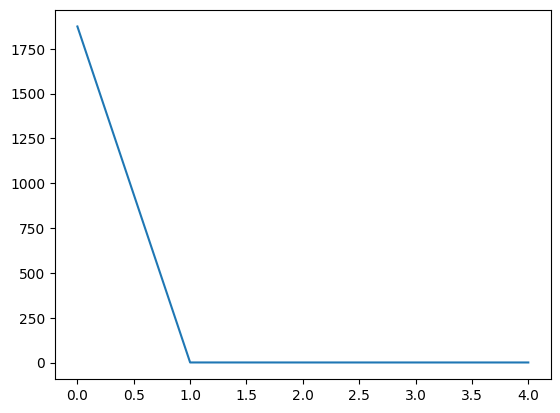

In [71]:
import matplotlib.pyplot as plt

plt.plot(loss_all)
# plt.plot(loss_valid_all)

In [72]:
from torch_geometric.explain.metric import groundtruth_metrics

avg_scores = []
model.eval()
for batch in test_data_batches:
    pred = model(batch.x, batch.edge_index).argmax(dim=1)
    scores = groundtruth_metrics(
        pred_mask=pred[batch.train_mask],
        target_mask=batch.y[batch.train_mask],
        threshold=0.5,
        metrics=["accuracy", "precision", "recall", "f1_score"]
    )
    avg_scores += [scores]

import numpy as np

np.asarray(avg_scores).mean(axis=0)

RuntimeError: Detected the following values in `preds`: tensor([2], device='cuda:0') but expected only the following values [0,1] since `preds` is a label tensor.

In [ ]:
from torch_geometric.explain.metric import groundtruth_metrics

avg_scores = []
model.eval()
skips = 0
for batch in tqdm(loader, total=data.x.shape[0]//batch_size):
    if batch.test_mask.sum() <= 0:
        skips += 1
        continue
    pred = model(batch.x, batch.edge_index).argmax(dim=1)

    scores = groundtruth_metrics(
        pred_mask=pred[batch.test_mask],
        target_mask=batch.y[batch.test_mask],
        threshold=0.5,
        metrics=["accuracy", "precision", "recall", "f1_score"]
    )
    avg_scores += [scores]

import numpy as np

print(f"Skips = {skips}")
np.asarray(avg_scores).mean(axis=0)